# VSB Powerline baseline

using spectrograms created in vsb_powerline_spectrograms

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import uuid
from os import listdir
from os.path import isfile, join
import glob

In [3]:
from fastai.vision import *

In [4]:
from fastai import *
from fastai.tabular import *
from fastai.utils import *

In [5]:
import fastai
print(fastai.__version__)

1.0.39.dev0


In [6]:
torch.cuda.set_device(0)

In [7]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]

In [8]:
DATE

'20181229'

In [9]:
UID

'd1a603dc'

In [10]:
image_size=300
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [11]:
path = Path('../input/')
train_path = path/'train_300_aug/'

In [12]:
test_path = path/'test/'

In [13]:
train_df = pd.read_csv(path/'metadata_train.csv')

In [14]:
test_df = pd.read_csv(path/'metadata_test.csv')

In [15]:
train_df.tail()

,signal_id,id_measurement,phase,target
8707,8707,2902,1,0
8708,8708,2902,2,0
8709,8709,2903,0,0
8710,8710,2903,1,0
8711,8711,2903,2,0


In [16]:
aug_df = pd.read_csv(path/'metadata_train.csv')

In [17]:
aug_df['signal_id'] = aug_df['signal_id'].astype(str)+'_flip_lr'

In [18]:
train_df = pd.concat([train_df, aug_df], ignore_index=True)

In [19]:
train_df.tail()

,signal_id,id_measurement,phase,target
17419,8707_flip_lr,2902,1,0
17420,8708_flip_lr,2902,2,0
17421,8709_flip_lr,2903,0,0
17422,8710_flip_lr,2903,1,0
17423,8711_flip_lr,2903,2,0


### Image Data

In [20]:
tfms = get_transforms(do_flip=False, max_rotate=0, max_zoom=0, max_lighting=0.05, max_warp=0, p_lighting=0.1, xtra_tfms=[jitter(magnitude=.0001)])

In [21]:
data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, suffix='.jpg')

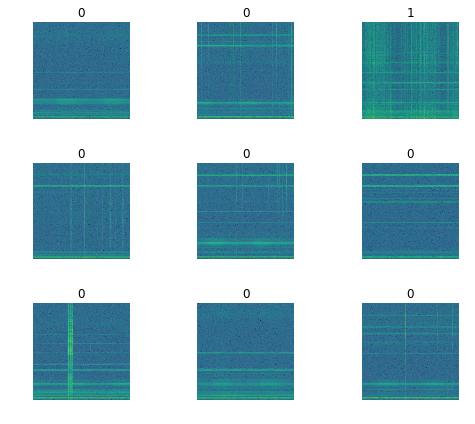

In [22]:
data.show_batch(rows=3, figsize=(7,6))

In [23]:
print(data.classes)
len(data.classes),data.c

[0, 1]


(2, 2)

## Training: resnet34

In [24]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [25]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate
1,0.211831,0.139348,0.049369
2,0.138045,0.100103,0.038749
3,0.094290,0.096219,0.037313
4,0.075837,0.087300,0.035017
5,0.052115,0.087694,0.035591


In [26]:
learn.save('aug_stage-1')

## Results

In [27]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

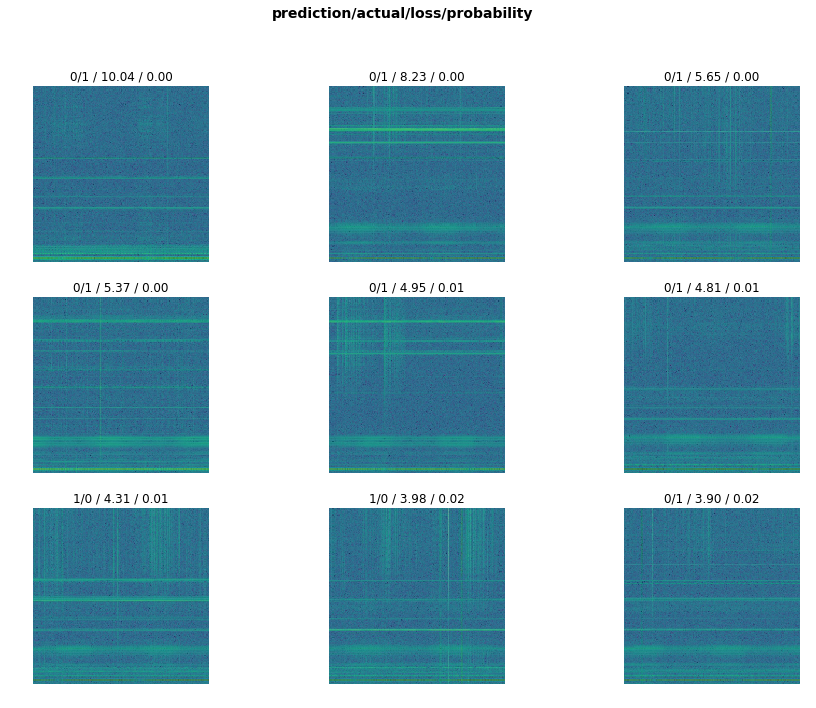

In [28]:
interp.plot_top_losses(9, figsize=(15,11))

In [29]:
doc(interp.plot_top_losses)

plot_top_losses [source] plot_top_losses ( `k` , `largest` = `True` , `figsize` = `(12, 12)` ) 
 
 Show images in top_losses along with their prediction, actual, loss, and probability of predicted class. 
 Show in docs

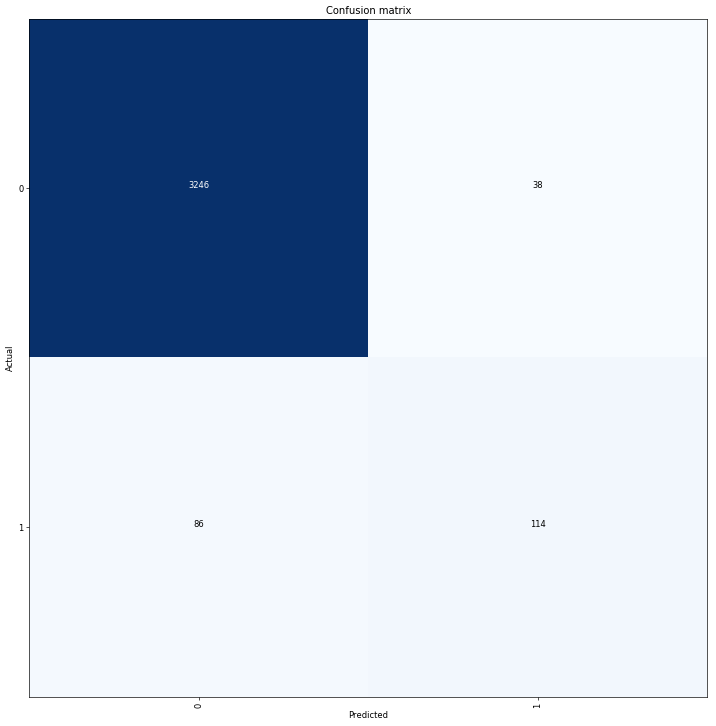

In [30]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [31]:
interp.most_confused(min_val=2)

[(1, 0, 86), (0, 1, 38)]

## Unfreezing, fine-tuning, and learning rates

In [32]:
learn.unfreeze()

In [33]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.103418,0.082918,0.033869


In [34]:
learn.load('aug_stage-1');

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


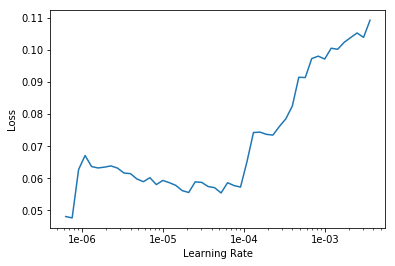

In [36]:
learn.recorder.plot()

In [37]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-6,2e-5))

epoch,train_loss,valid_loss,error_rate
1,0.052115,0.087074,0.035017
2,0.042155,0.083175,0.031286
3,0.027098,0.081437,0.029564
4,0.018512,0.079583,0.030425
5,0.017328,0.080648,0.027268


In [38]:
learn.save('aug_stage-2_unfeeze')

### 1x1 prediction

In [39]:
#test_images = [f for f in listdir(test_path) if isfile(join(test_path, f))]

In [40]:
test_images = glob.glob(str(test_path)+"/*.jpg")

In [41]:
len(test_images)

20337

In [42]:
assert 20337 == len(test_images)

In [43]:
img = open_image(test_images[0])
type(img)

fastai.vision.image.Image

In [44]:
cat, val, probs=learn.predict(img)

In [45]:
cat.__str__()

'0'

In [46]:
d={}
for i,fname in enumerate(test_images):
    im_name=fname.split('/')[3]
    signal_id = im_name[:im_name.index(".")]
    img = open_image(test_images[i])
    cat, val, probs=learn.predict(img)
    d[signal_id]=cat.__str__()
    #print(f'signal_id: {signal_id}, cat: {cat.__str__()}, val: {val}')

In [47]:
df_sub=pd.DataFrame.from_dict(d, orient='index')

In [48]:
df_sub=df_sub.reset_index()
df_sub.head()

,index,0
0,28678,0
1,24274,0
2,24224,0
3,12637,0
4,23610,0


In [49]:
df_sub.rename(columns={'index': 'signal_id', 0: 'target'}, inplace=True)

In [50]:
df_sub.head()

,signal_id,target
0,28678,0
1,24274,0
2,24224,0
3,12637,0
4,23610,0


In [51]:
len(df_sub)

20337

In [52]:
df_sub.to_csv(path/f'submissions/submission_aug_stage-2_unfeeze_{DATE}_{UID}.csv', index=False)
#submission 2. 0.404
#submission_aug_stage-2_unfeeze_20181229_d1a603dc.csv

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [53]:
data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, suffix='.jpg', bs=4)
#data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
#                                   size=image_size, bs=bs//2).normalize(imagenet_stats)

In [54]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


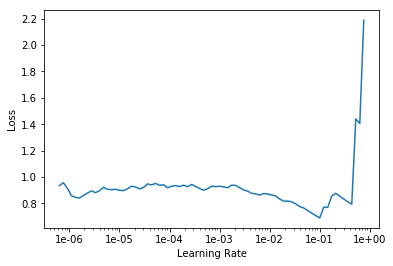

In [55]:
learn.lr_find()
learn.recorder.plot()

In [56]:
max_lr = 1e-3
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(8, lrs)

epoch,train_loss,valid_loss,error_rate
1,0.164189,0.160105,0.051378
2,0.136634,0.128991,0.047359
3,0.118678,0.130966,0.045637
4,0.158146,0.117710,0.045350
5,0.121506,0.114018,0.043628
6,0.072220,0.130025,0.048794
7,0.132934,0.112650,0.044489
8,0.132413,0.118317,0.043915


In [57]:
#learn.fit_one_cycle(8)

In [58]:
learn.save('aug_stage-1-50')

In [59]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.209580,0.139430,0.054535
2,0.162383,0.122988,0.055683
3,0.106317,0.099513,0.040184


In [60]:
learn.save('aug_stage-2-50')

In [61]:
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.114230,0.130576,0.050804
2,0.119835,2.006721,0.049656
3,0.085578,0.974430,0.041906


In [62]:
learn.save('aug_stage-2-2-50')

In [63]:
#learn.load('baseline_stage-1-50');

In [64]:
interp = ClassificationInterpretation.from_learner(learn)

In [65]:
interp.most_confused(min_val=2)

[(1, 0, 126), (0, 1, 20)]

In [66]:
### Predict

In [72]:
learn.load('aug_stage-2-50')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (13940 items)
[Category 0, Category 0, Category 0, Category 1, Category 1]...
Path: ../input/train_300_aug
x: ImageItemList (13940 items)
[Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300)]...
Path: ../input/train_300_aug;

Valid: LabelList
y: CategoryList (3484 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: ../input/train_300_aug
x: ImageItemList (3484 items)
[Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300)]...
Path: ../input/train_300_aug;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential

In [73]:
d={}
for i,fname in enumerate(test_images):
    im_name=fname.split('/')[3]
    signal_id = im_name[:im_name.index(".")]
    img = open_image(test_images[i])
    cat, val, probs=learn.predict(img)
    d[signal_id]=cat.__str__()
    #print(f'signal_id: {signal_id}, cat: {cat.__str__()}, val: {val}')

In [74]:
df_sub_50_u=pd.DataFrame.from_dict(d, orient='index')

In [75]:
df_sub_50_u=df_sub_50_u.reset_index()


In [76]:
df_sub_50_u.rename(columns={'index': 'signal_id', 0: 'target'}, inplace=True)
df_sub_50_u.head()

,signal_id,target
0,28678,0
1,24274,0
2,24224,0
3,12637,0
4,23610,0


In [77]:
df_sub_50_u.to_csv(path/f'submissions/submission_aug_resnet-50_unfeeze-2-2_{DATE}_{UID}.csv', index=False)

In [ ]:
#submission 3 0.478
#submission_aug_resnet-50_unfeeze-2-2_20181229_d1a603dc.csv
